# FVG

so today i tried doing the fvg thing and i was able computing when and fvg happened and when it returned. now its my task to check those events. and also see how i can group them in different regimes or something like that. 

GPT Link for continuation of the conversation:
https://chatgpt.com/share/6945b36b-b5c0-8004-a7c9-017617702071




In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/ducjeremyvu/alpha/price_data/US500_Minute5_20251219_1816.csv")

df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").reset_index(drop=True)

# Bar A (i-2) and Bar C (i)
A_high = df["High"].shift(2)
A_low  = df["Low"].shift(2)
B_open = df["Open"].shift(1)
B_close = df["Close"].shift(1)
C_low  = df["Low"]
C_high = df["High"]

# FVG conditions
bull = C_low > A_high
bear = C_high < A_low

# Build event table
events = pd.DataFrame({
    "Time": df["Time"],
    "Lower": np.where(bull, A_high, np.where(bear, C_high, np.nan)),
    "Upper": np.where(bull, C_low,  np.where(bear, A_low,  np.nan)),
    "B_size": (B_close - B_open).abs(),
})

# Direction as categorical (pandas-native)
events["Direction"] = np.nan
events.loc[bull, "Direction"] = "BULL"
events.loc[bear, "Direction"] = "BEAR"

# Keep only real FVGs
events = events.dropna(subset=["Direction"]).copy()

# Gap size
events["GapSize"] = events["Upper"] - events["Lower"]

events.head(10)

/var/folders/h_/czc68f1s1qbcn01xxzxjq4c40000gn/T/ipykernel_64471/3330977488.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'BULL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  events.loc[bull, "Direction"] = "BULL"


,Time,Lower,Upper,B_size,Direction,GapSize
6,2025-09-10 14:30:00,6552.3,6554.8,5.2,BEAR,2.5
7,2025-09-10 14:35:00,6551.0,6551.3,2.7,BEAR,0.3
16,2025-09-10 15:20:00,6538.8,6542.0,5.3,BEAR,3.2
20,2025-09-10 15:40:00,6540.8,6541.5,5.2,BULL,0.7
21,2025-09-10 15:45:00,6543.3,6544.0,2.7,BULL,0.7
22,2025-09-10 15:50:00,6545.5,6546.3,0.7,BULL,0.8
24,2025-09-10 16:00:00,6545.5,6546.3,3.0,BEAR,0.8
28,2025-09-10 16:20:00,6542.8,6543.3,1.5,BEAR,0.5
29,2025-09-10 16:25:00,6541.3,6542.3,1.7,BEAR,1.0
32,2025-09-10 16:40:00,6537.0,6537.3,2.2,BEAR,0.3


In [7]:
# Gap size must always be positive
assert (events["GapSize"] > 0).all()

# Direction should only be BULL or BEAR
assert set(events["Direction"].unique()) <= {"BULL", "BEAR"}

In [9]:
returns = []
bars_to_return = []

for idx, row in events.iterrows():
    i = row.name  # index in df
    lower = row["Lower"]
    upper = row["Upper"]

    future = df.iloc[i+1:]

    touched = future[
        (future["Low"] <= upper) &
        (future["High"] >= lower)
    ]

    if len(touched) == 0:
        returns.append(False)
        bars_to_return.append(np.nan)
    else:
        returns.append(True)
        bars_to_return.append(touched.index[0] - i)

In [10]:
events["Returned"] = returns
events["BarsToReturn"] = bars_to_return

In [11]:
events

,Time,Lower,Upper,B_size,Direction,GapSize,Returned,BarsToReturn
6,2025-09-10 14:30:00,6552.3,6554.8,5.2,BEAR,2.5,True,250.0
7,2025-09-10 14:35:00,6551.0,6551.3,2.7,BEAR,0.3,True,1.0
16,2025-09-10 15:20:00,6538.8,6542.0,5.3,BEAR,3.2,True,1.0
20,2025-09-10 15:40:00,6540.8,6541.5,5.2,BULL,0.7,True,8.0
21,2025-09-10 15:45:00,6543.3,6544.0,2.7,BULL,0.7,True,3.0
...,...,...,...,...,...,...,...,...
19536,2025-12-19 15:45:00,6822.0,6823.3,8.5,BEAR,1.3,True,3.0
19540,2025-12-19 16:05:00,6820.0,6820.5,5.0,BULL,0.5,False,NaN
19541,2025-12-19 16:10:00,6822.5,6823.0,3.5,BULL,0.5,True,1.0
19545,2025-12-19 16:30:00,6828.5,6829.3,3.7,BULL,0.8,True,1.0


plotting the data now and check if there is anythign interesting 

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

Time            2025-09-10 15:20:00
Lower                        6538.8
Upper                        6542.0
B_size                          5.3
Direction                      BEAR
GapSize                         3.2
Returned                       True
BarsToReturn                    1.0
Name: 16, dtype: object


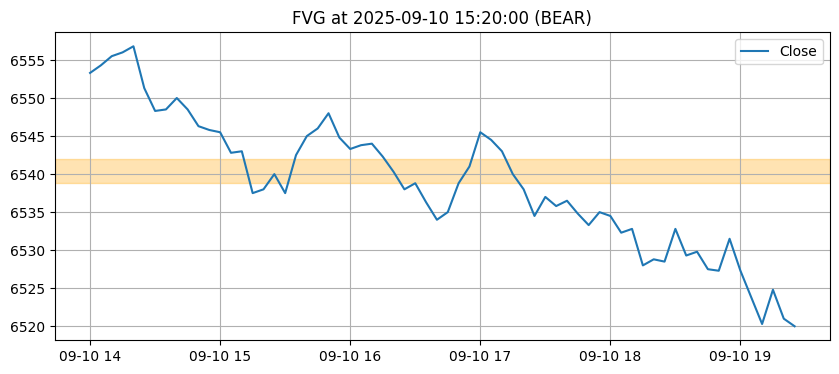

In [15]:
i = events.index[2]  # pick one FVG
row = events.loc[i]

start = max(i - 20, 0)
end = i + 50

slice_df = df.iloc[start:end]
print(row)
plt.plot(slice_df["Time"], slice_df["Close"], label="Close")
plt.axhspan(row["Lower"], row["Upper"], color="orange", alpha=0.3)

plt.title(f"FVG at {row['Time']} ({row['Direction']})")
plt.legend()
plt.show()